<a href="https://colab.research.google.com/github/iisuslik43/dul/blob/hw3/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

! cp -r "drive/My Drive/dul/" .

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
! pip install pymorphy2 >> /dev/null
! pip install transformers >> /dev/null
! pip install wandb >> /dev/null
! wandb login b569130067842c47dc059479b75930c8f598012a

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [0]:
import numpy as np
import torch
import torch.utils.data
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm_notebook as tqdm
import pickle
import torch.nn.functional as F
import os
import csv

import wandb
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Sampling

In [0]:
def sample_data_1():
  count = 100000
  rand = np.random.RandomState(0)
  return [[1.0, 2.0]] + rand.randn(count, 2) * [[5.0, 1.0]]
def sample_data_2():
  count = 100000
  rand = np.random.RandomState(0)
  return [[1.0, 2.0]] + (rand.randn(count, 2) * [[5.0, 1.0]]).dot(
  [[np.sqrt(2) / 2, np.sqrt(2) / 2], [-np.sqrt(2) / 2, np.sqrt(2) / 2]])

def sample_data_3():
  count = 100000
  rand = np.random.RandomState(0)
  a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
  b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
  c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
  -np.sin(np.linspace(0, np.pi, count // 3))]

  c += rand.randn(*c.shape) * 0.2
  data_x = np.concatenate([a, b, c], axis=0)
  data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
  perm = rand.permutation(len(data_x))
  return data_x[perm], data_y[perm]

In [0]:
data1 = sample_data_1()
data2 = sample_data_2()
data3, y3 = sample_data_3()

#Models code


In [0]:
class VAE1(nn.Module):
  def __init__(self, dim=2, latent_dim=2):
    super().__init__()
    self.dim = dim
    self.latent_dim = latent_dim

    self.normal = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1.0]))

    self.encoder = nn.Sequential(
      nn.Linear(self.dim, 32),
      nn.ReLU(True)
    )

    self.mu_z = nn.Linear(32, self.latent_dim)
    self.gamma_z = nn.Linear(32, self.latent_dim)

        

    self.decoder = nn.Sequential(
      nn.Linear(self.latent_dim, 32),
      nn.ReLU(True)
    )

    self.mu_x = nn.Linear(32, self.dim)
    self.gamma_x = nn.Linear(32, self.dim)

    self.gamma_x.weight.data.fill_(0.01)
    self.gamma_z.weight.data.fill_(0.01)

  def sample(self, mu, gamma):
    if self.training:
        #std_z = Variable(torch.from_numpy(np.random.normal(0, 1, size=sigma.size())).float())
        std_z = self.normal.sample(mu.shape).to(device).reshape(mu.shape)
        encoding = std_z * gamma + mu
        return encoding
    else:
        return mu

  def encode(self, x):
    x = self.encoder(x)
    mu = self.mu_z(x)
    gamma = self.gamma_z(x)
    gamma = torch.exp(0.5 * gamma)
    return mu, gamma

  def decode(self, z):
    z = self.decoder(z)
    mu = self.mu_x(z)
    gamma = self.gamma_x(z)
    gamma = torch.exp(0.5 * gamma)
    return mu, gamma

  def kl(self, mu, gamma):
    dim = mu.shape[1]
    return 0.5 * (gamma.sum(dim=-1) + (mu ** 2).sum(dim=-1) - dim - torch.log(gamma.prod(dim=-1)+ 1e-9)).mean()

  def prob_loss(self, x, mu, gamma):
    prob = -0.5 * (torch.log(2 * np.pi * gamma) + (x - mu) ** 2 / gamma)
    loss = -prob.sum(dim=1)
    loss = loss.mean()
    return loss

  def forward(self, x):
    mu_z, gamma_z = self.encode(x)
    z = self.sample(mu_z, gamma_z)
    mu_x, gamma_x = self.decode(z)
    x1 = self.sample(mu_x, gamma_x)
    return x1, self.kl(mu_z, gamma_z), self.prob_loss(x, mu_x, gamma_x)
    

In [0]:
class VAE2(VAE1):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.gamma_x = nn.Linear(32, 1)
    self.gamma_x.weight.data.fill_(0.01)

  def forward(self, x):
    mu_z, gamma_z = self.encode(x)
    z = self.sample(mu_z, gamma_z)
    mu_x, gamma_x = self.decode(z)
    gamma_x = gamma_x.repeat((1, self.dim))
    x1 = self.sample(mu_x, gamma_x)
    return x1, self.kl(mu_z, gamma_z), self.prob_loss(x, mu_x, gamma_x)

In [0]:
def train(model, data, n_epochs=10, wandb_name=None, batch_size=128):
  split = int(len(data) * 0.8)
  dataset_train = torch.utils.data.DataLoader(data[:split],
                                              batch_size=batch_size,
                                              shuffle=True)
  dataset_test = torch.utils.data.DataLoader(data[split:],
                                             batch_size=batch_size,
                                             shuffle=True)
  optimizer = torch.optim.Adam(params=model.parameters())
  if wandb_name is not None:
    wandb.init(name=wandb_name, project="dul-hw3-vae")
    wandb.watch(model)
  for epoch in tqdm(range(1, n_epochs + 1)):
      train_losses = {'ELBO': [], 'KL': [], 'PROB': []}
      test_losses = {'ELBO': [], 'KL': [], 'PROB': []}
      for x_batch in dataset_train:
          optimizer.zero_grad()
          x_batch = x_batch.float().to(device)
          output, kl, prob_loss = model(x_batch)
          loss = kl + prob_loss
          loss.backward()
          optimizer.step()

          train_losses['ELBO'].append(loss.item())
          train_losses['KL'].append(kl.item())
          train_losses['PROB'].append(prob_loss.item())

      with torch.no_grad():
          model.eval()
          for x_test in dataset_test:
              x_test = x_test.float().to(device)
              output_test, kl_test, prob_loss_test = model(x_test)
              loss_test = kl_test + prob_loss_test
              test_losses['ELBO'].append(loss_test.item())
              test_losses['KL'].append(kl_test.item())
              test_losses['PROB'].append(prob_loss_test.item())
          model.train()
      if wandb_name is not None:
          loss_log = {}
          for name, values in train_losses.items():
            values = [v for v in values if v == v and v != float('inf')]
            loss_log[name + ' train'] = np.mean(values)
          for name, values in test_losses.items():
            values = [v for v in values if v == v and v != float('inf')]
            loss_log[name + ' test'] = np.mean(values)
          wandb.log(loss_log)

# 1 a


In [0]:
def sample(model, data):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.plot(data[:,0], data[:,1], 'bo')
    ax1.set_title('Original')
    model.eval()
    with torch.no_grad():
        for i in range(20):
          z = model.normal.sample((100, 2)).reshape(100, 2).to(device)
          mu_x, gamma_x = model.decode(z)
          x1 = model.sample(mu_x, gamma_x).cpu().numpy()
          ax2.plot(x1[:,0], x1[:, 1], 'bo')
    ax2.set_title('Eval generation')
    model.train()
    with torch.no_grad():
        for i in range(20):
          z = model.normal.sample((100, 2)).reshape(100, 2).to(device)
          mu_x, gamma_x = model.decode(z)
          x1 = model.sample(mu_x, gamma_x).cpu().numpy()
          ax3.plot(x1[:,0], x1[:, 1], 'bo')
    ax3.set_title('Train generation')
    ax1.label_outer()
    ax2.label_outer()
    ax3.label_outer()
    plt.show()

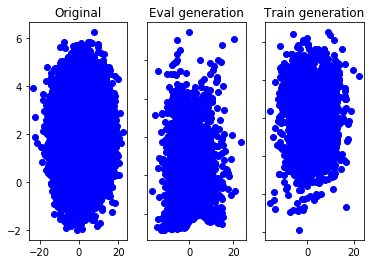

In [15]:
model_11 = VAE1().to(device)
train(model_11, data1, n_epochs=40, wandb_name='Method # 1 Data # 1')
sample(model_11, data1)

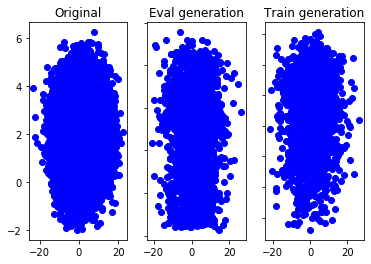

In [19]:
model_12 = VAE2().to(device)
train(model_12, data1, n_epochs=40, wandb_name='Method # 2 Data # 1')
sample(model_12, data1)

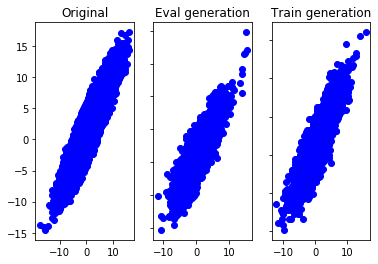

In [20]:
model_21 = VAE1().to(device)
train(model_21, data2, n_epochs=60, wandb_name='Method # 1 Data # 2')
sample(model_21, data2)

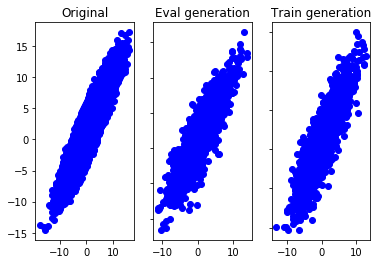

In [21]:
model_22 = VAE2().to(device)
train(model_22, data2, n_epochs=60, wandb_name='Method # 2 Data # 2')
sample(model_22, data2)

#1 b

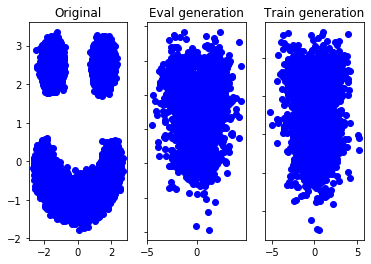

In [22]:
model_31 = VAE1().to(device)
train(model_31, data3, n_epochs=300, wandb_name='Method # 1 Data # 3')
sample(model_31, data3)

In [0]:
def sample_z(model, data, y):
    data = data[len(data) - 2001:]
    y = y[len(data) - 2001:]
    colors = {0: 'r', 1: 'g', 2: 'b'}
    with torch.no_grad():
        model.eval()
        for i in range(10):
            x = data[i * 200: (i + 1) * 200]
            x = torch.tensor(x).float().to(device)
            mu, gamma = model.encode(x)
            z = model.sample(mu, gamma).cpu().numpy()
            y_sample = y[i * 200: (i + 1) * 200]
            for x1, y1 in zip(z, y_sample):
              plt.plot(x1[0], x1[1], colors[y1] + 'o')

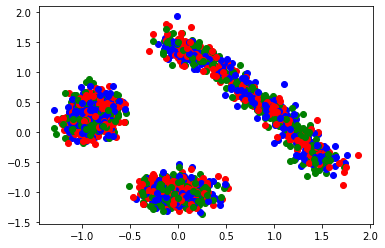

In [24]:
sample_z(model_31, data3, y3)

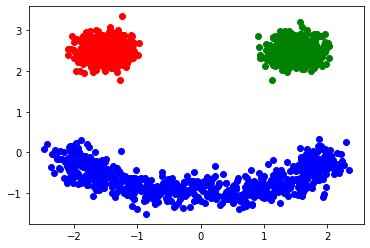

In [26]:

colors = {0: 'r', 1: 'g', 2: 'b'}
for x1, y1 in zip(data3[:2000], y3[:2000]):
    plt.plot(x1[0], x1[1], colors[y1] + 'o')

# 2 a


In [0]:
with open('dul/hw3-q2.pkl', 'rb') as f:
  svhn_dataset = pickle.load(f)

In [0]:
class GatedShortcutConnection(nn.Module):
  def __init__(self, c):
    super().__init__()
    self.conv1 = nn.Conv2d(c, c, kernel_size=1)
    self.conv2 = nn.Conv2d(c, c, kernel_size=1)
    self.conv1.weight.data.fill_(0.01)
    self.conv2.weight.data.fill_(0.01)
    self.sigmoid = nn.Sigmoid()
                 
  def forward(self, x):
      return self.conv1(x) * self.sigmoid(self.conv2(x))

class ResidualStack(nn.Module):
  def __init__(self, c):
    super().__init__()
    layers = []
    for _ in range(5):
        layers += [nn.ReLU(),
                   nn.Conv2d(2 * c, c, kernel_size=3, stride=1, padding=1),
                   nn.ReLU(),
                   nn.Conv2d(c, 2 * c, kernel_size=3, stride=1, padding=1),
                   GatedShortcutConnection(2 * c)]
    layers += [nn.ReLU()]
    self.layers = nn.Sequential(*layers)

  def forward(self, x):
    return self.layers(x)

In [0]:
class Encoder(nn.Module):
  def __init__(self, c):
    super().__init__()
    self.c = c
    layers = [nn.Conv2d(3, 2 * c, kernel_size=4, stride=2, padding=1),
              nn.ReLU(),
              nn.Conv2d(2 * c, 4 * c, kernel_size=4, stride=2, padding=1),
              nn.ReLU(),
              nn.Conv2d(4 * c, 2 * c, kernel_size=3, stride=1, padding=1),
              ResidualStack(c)
              ]
    self.layers = nn.Sequential(*layers)

  def forward(self, x):
    x = self.layers(x)
    x = x.reshape(-1, 2, self.c * 8 * 8)
    mu, gamma = x[:, 0, :], x[:, 1, :]
    gamma = torch.exp(gamma)
    return mu, gamma


class Decoder(nn.Module):
  def __init__(self, c):
    super().__init__()
    self.c = c
    layers = [nn.Conv2d(c, 4 * c, kernel_size=3, stride=1, padding=1),
              ResidualStack(2 * c),
              nn.ConvTranspose2d(4 * c, 2 * c, kernel_size=4, stride=2, padding=1),
              nn.ReLU(),
              nn.ConvTranspose2d(2 * c, 3, kernel_size=4, stride=2, padding=1)]
    self.layers = nn.Sequential(*layers)

  def forward(self, x):
    x = x.reshape(-1, self.c, 8, 8)

    return self.layers(x)

In [0]:
class VAE_big(nn.Module):
  def __init__(self, c):
    super().__init__()

    self.normal = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1.0]))

    self.encoder = Encoder(c)

    self.decoder = Decoder(c)

  def sample(self, mu, gamma):
    if self.training:
        #std_z = Variable(torch.from_numpy(np.random.normal(0, 1, size=sigma.size())).float())
        std_z = self.normal.sample(mu.shape).to(device).reshape(mu.shape)
        encoding = std_z * gamma + mu
        return encoding
    else:
        return mu


  def kl(self, mu, gamma):
    dim = mu.shape[1]
    return 0.5 * (gamma.sum(dim=-1) + (mu ** 2).sum(dim=-1) - dim - torch.log(gamma.prod(dim=-1)+ 1e-9)).mean()

  def forward(self, x):
    x = x.permute(0, 3, 1, 2)
    mu_z, gamma_z = self.encoder(x)
    z = self.sample(mu_z, gamma_z)
    # mu_x, gamma_x = self.decoder(z)
    # x1 = self.sample(mu_x, gamma_x)
    x1 = self.decoder(z)
    x1 = x1.permute(0, 2, 3, 1)
    return x1, self.kl(mu_z, gamma_z)
    

In [0]:
class VAELossL2(nn.Module):
  def __init__(self):
    super().__init__()
    self.mse = nn.MSELoss()
  
  def forward(self, target, output, kl):
    l2 = self.mse(output, target)
    return l2 + kl, l2

In [0]:
def train_svhn(model, data_train, data_val, n_epochs=10, wandb_name=None, batch_size=32):
  criterion = VAELossL2()
  dataset_train = torch.utils.data.DataLoader(data_train,
                                              batch_size=batch_size,
                                              shuffle=True)
  dataset_test = torch.utils.data.DataLoader(data_val,
                                             batch_size=batch_size,
                                             shuffle=True)
  optimizer = torch.optim.Adam(params=model.parameters())
  if wandb_name is not None:
    wandb.init(name=wandb_name, project="dul-hw3-vae")
    wandb.watch(model)
  for epoch in tqdm(range(1, n_epochs + 1)):
      train_losses = {'ELBO': [], 'KL': [], 'L2': []}
      test_losses = {'ELBO': [], 'KL': [], 'L2': []}
      for x_batch in dataset_train:
          optimizer.zero_grad()
          x_batch = x_batch.float().to(device)
          output, kl = model(x_batch)
          loss, l2 = criterion(x_batch, output, kl)
          loss.backward()
          optimizer.step()

          train_losses['ELBO'].append(loss.item())
          train_losses['KL'].append(kl.item())
          train_losses['L2'].append(l2.item())
          if kl.item() != kl.item():
            print('NAN')
            raise ValueError('NAN HAPPENED')

      with torch.no_grad():
          model.eval()
          for x_test in dataset_test:
              x_test = x_test.float().to(device)
              output_test, kl_test = model(x_test)
              loss, l2 = criterion(x_test, output_test, kl_test)
              if kl_test.item() != kl_test.item():
                print('NAN')
                raise ValueError('NAN HAPPENED')
              test_losses['ELBO'].append(loss.item())
              test_losses['KL'].append(kl_test.item())
              test_losses['L2'].append(l2.item())
          model.train()
      if wandb_name is not None:
          loss_log = {}
          for name, values in train_losses.items():
            values = [v for v in values if v == v and v != float('inf')]
            loss_log[name + ' train'] = np.mean(values)
          for name, values in test_losses.items():
            values = [v for v in values if v == v and v != float('inf')]
            loss_log[name + ' test'] = np.mean(values)
          wandb.log(loss_log)

In [0]:
model_svhn_1 = VAE_big(64).to(device)
go = 'Method # 1 SVHN'
train_svhn(model_svhn_1, VAELossL2(), svhn_dataset['train'], svhn_dataset['valid'], n_epochs=3, wandb_name=go)